In [89]:
import sys
sys.path.append('../') 
sys.path.append('../../') 
import numpy as np
import pandas as pd
import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge
from scipy.stats import zscore, mstats
from CLR.constrained_linear_regression import ConstrainedLinearRegression
import quantutils.regression_utils as regutils
import quantutils.general_utils as genutils

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Things to touch on

1) How to use Rolling Regression Function

2) Regularisation 

In [83]:
df_feature = pd.read_csv('../Data/df_feature.csv', index_col=0, parse_dates=True)


In [85]:
y_variable = 'UTD@CPIDATA_sa_pct_change_l0_ma2'
X_variables = ['UTD@CPIDATA_sa_pct_change_l0_ma2', 'UTD@CPIDATA_sa_pct_change_l0_ma3',
               ]
shift_window = 1
df_featurec = df_feature.copy()

df_featurec['target'] = df_featurec[y_variable].shift(-shift_window)
df_featurec = df_featurec[['target'] + X_variables]

In [86]:
l1_ratio = 2.5
df_results, fitted_models, X_series, y_series = regutils.rolling_regression(df_featurec, 60, l1_ratio=0.0,
                                                                                             normalize=True, dropna=True,
                                                                                             shift_window=2)


df_results_reg_rescale, fitted_models_reg_rescale, X_series_reg_rescale, y_series_reg_rescale = regutils.rolling_regression(df_featurec, 60, l1_ratio=l1_ratio,
                                                                                             normalize=True, dropna=True,
                                                                                             shift_window=2,
                                                                                             ridge_proportion=False,
                                                                                             rescale=True)


df_results_reg, fitted_models_reg, X_series_reg, y_series_reg = regutils.rolling_regression(df_featurec, 60, l1_ratio=l1_ratio,
                                                                                             normalize=True, dropna=True,
                                                                                             shift_window=2,
                                                                                             ridge_proportion=False,
                                                                                             rescale=False)

c:\Users\Wazir\Documents\wazewww\Macro\RegressionTools\..\quantutils\regression_utils.py:122: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  n_samples, n_features_plus_one = datac.shape
c:\Users\Wazir\Documents\wazewww\Macro\RegressionTools\..\quantutils\regression_utils.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_X = datac.drop('target', axis=1)
c:\Users\Wazir\anaconda3\envs\regtool\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ConstrainedLinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Wazir\anaconda3\envs\regtool\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ConstrainedLinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Wazir\anac

In [87]:

def plot_predictions(df_results, df_feature, start_date=None):
    df =pd.concat([df_results['predictions'], df_feature['target']], axis=1)
    if start_date is not None:
        df = df[start_date:]
    
    print(f'Corr: {df.corr().values[0][1].round(3)}')
    print(f'MSE: {(((df["predictions"] - df["target"])**2).mean()**(0.5)).round(5)}')
    fig ,ax = plt.subplots(1, 3, figsize=(16, 6))
    df.plot.scatter('predictions', 'target', ax=ax[0], title='Predictions vs Target')
    df.plot(ax=ax[1])
    df_results.drop('predictions', axis=1).dropna()[start_date:].plot(ax=ax[2], title='Coefficients')
    ax[2].legend(bbox_to_anchor=(1.0,1.0))
    plt.show()

Corr: 0.766
MSE: 0.0088


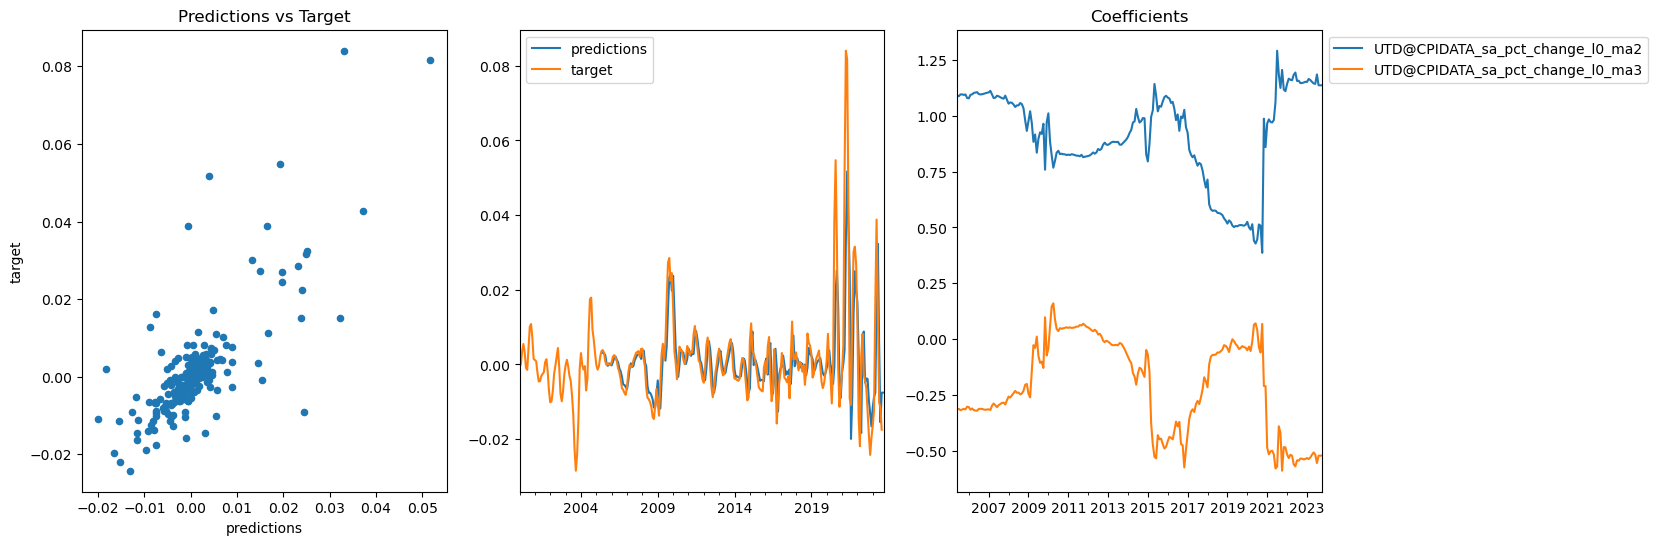

Corr: 0.763
MSE: 0.00926


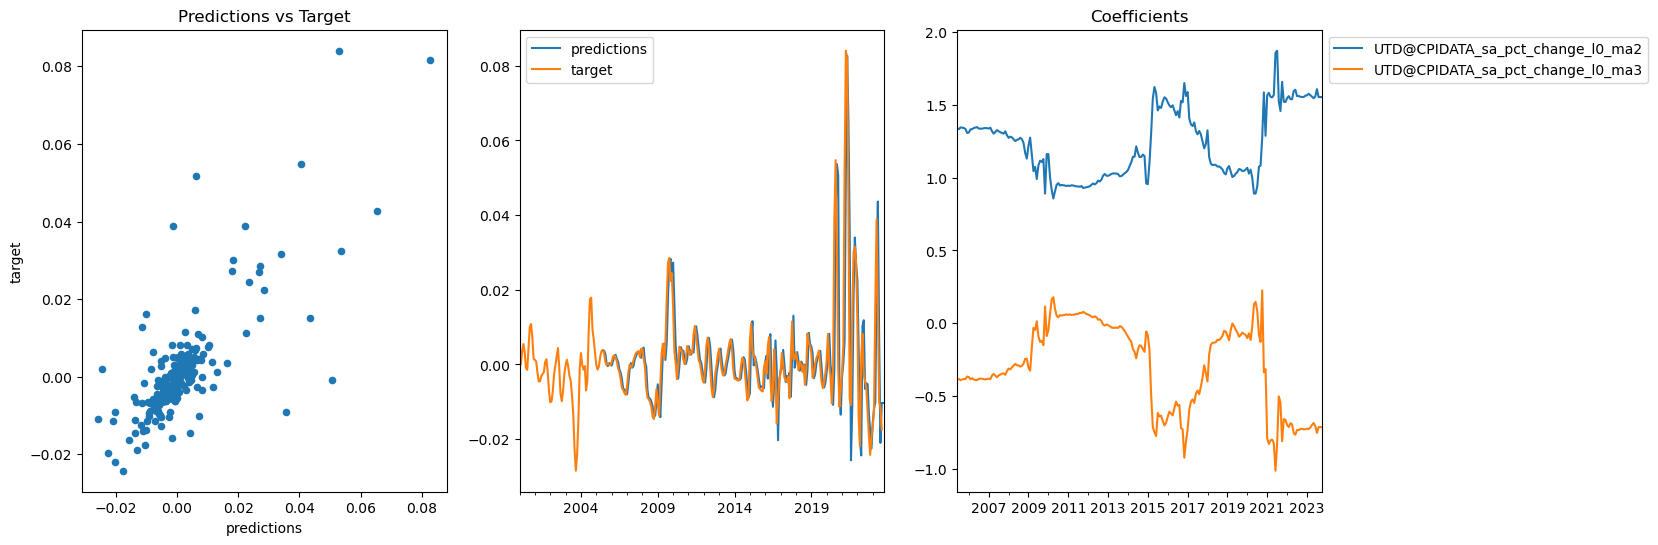

Corr: 0.77
MSE: 0.00865


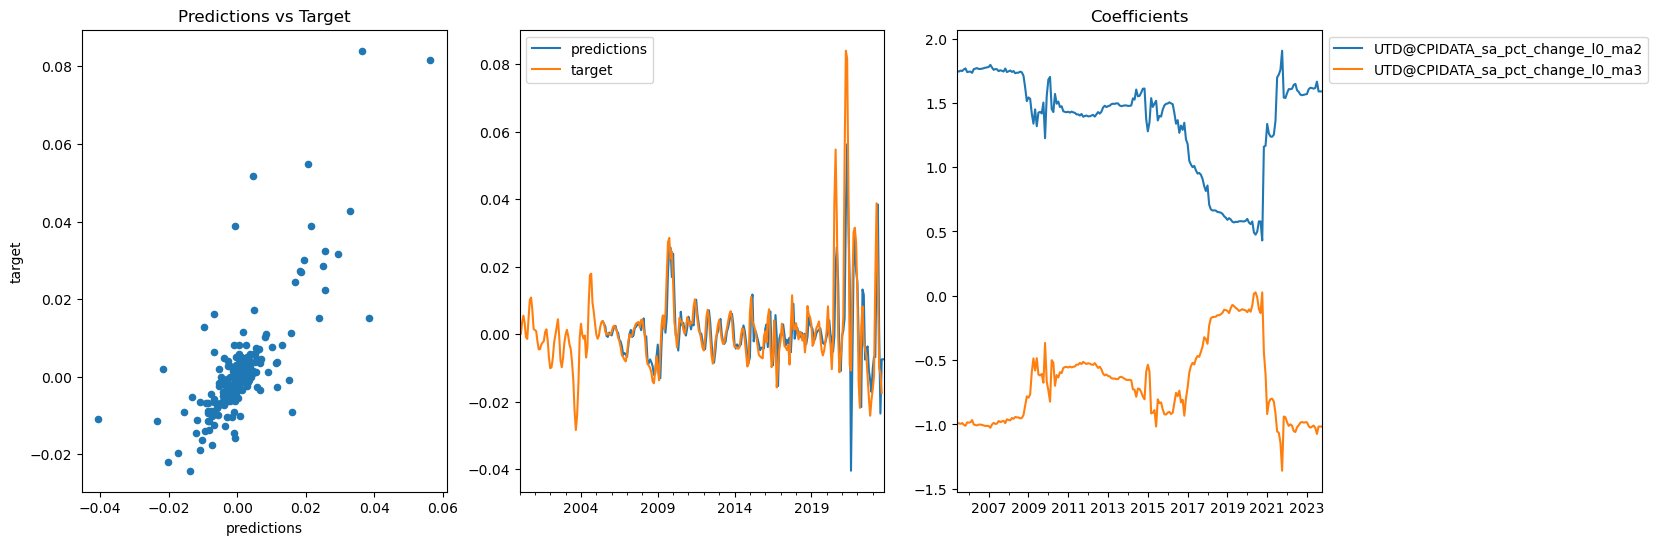

In [88]:
plot_predictions(df_results_reg, df_featurec, '2000-01-01')
plot_predictions(df_results_reg_rescale, df_featurec, '2000-01-01')
plot_predictions(df_results, df_featurec, '2000-01-01')

### How to generate df_features

How do we generate df_features from scratch?

In [97]:
## Start with raw_data
df_monthly = pd.read_excel('../Data/sample_data.xlsx')
df_monthly = df_monthly.iloc[1:, :].rename(columns={'Unnamed: 0': 'Date'})
df_monthly.index = pd.to_datetime(df_monthly['Date'])
df_monthly = df_monthly.drop('Date', axis=1)
df_monthly

,UTD@CPIDATA,UTDN@CPIDATA,UVIMAN@USECON,R441110U@PPIR,R4413@PPIR,S141101@PPI,FCM5@USECON
Date,,,,,,,
2000-01-31,153.9,153.9,109.1,NaN,NaN,133.4,6.58
2000-02-29,153,152.998,109.5,NaN,NaN,132.7,6.68
2000-03-31,153,152.975,110.1,NaN,NaN,132.7,6.5
2000-04-30,154,153.975,109.8,NaN,NaN,132.8,6.26
2000-05-31,155.4,155.385,110.2,NaN,NaN,133.5,6.69
...,...,...,...,...,...,...,...
2023-06-30,198.746,202.007,215.1,113.417,241.519,139.972,3.95
2023-07-31,196.086,201.624,211.7,105.34,241.128,140.277,4.14
2023-08-31,193.671,198.768,212.2,107.378,242.503,140.669,4.31


To generate the features, we need to use the class Variable from regutils.

It takes 3 arguments
- transformation: pct_change, diff, lvl
- seasonal: True or False
- y_variable: True or False, whether it is target variable or not

In [99]:
reg_variables_dict = {}
# Say our target variable is UTD@CPIDATA, and we want to SA it
# Note that if you choose something to be y_variable, you don't need to choose it for X as well, since the features will be automatically generated
reg_variables_dict['UTD@CPIDATA'] = regutils.Variable('pct_change', True, True)
# Our X variable is UTDN@CPIDATA	
reg_variables_dict['UTDN@CPIDATA'] = regutils.Variable('pct_change', True, False)



In [102]:
df_feature, seasonal_adj_dict = regutils.bulk_feature_engineering(df_monthly, reg_variables_dict)

seasonally adjusting UTD@CPIDATA...
seasonally adjusting UTDN@CPIDATA...


In [104]:
df_feature.columns

Index(['UTD@CPIDATA_sa_pct_change_l0_ma2', 'UTD@CPIDATA_sa_pct_change_l0_ma3',
       'UTD@CPIDATA_sa_pct_change_l1_ma2', 'UTD@CPIDATA_sa_pct_change_l1_ma3',
       'UTD@CPIDATA_sa_pct_change_l2_ma2', 'UTD@CPIDATA_sa_pct_change_l2_ma3',
       'UTD@CPIDATA_sa_pct_change_l3_ma2', 'UTD@CPIDATA_sa_pct_change_l3_ma3',
       'UTD@CPIDATA_sa_pct_change_l4_ma2', 'UTD@CPIDATA_sa_pct_change_l4_ma3',
       'UTD@CPIDATA_sa_pct_change1_l0', 'UTD@CPIDATA_sa_pct_change2_l0',
       'UTD@CPIDATA_sa_pct_change3_l0', 'UTD@CPIDATA_sa_pct_change4_l0',
       'UTDN@CPIDATA_sa_pct_change_l0_ma2',
       'UTDN@CPIDATA_sa_pct_change_l0_ma3',
       'UTDN@CPIDATA_sa_pct_change_l1_ma2',
       'UTDN@CPIDATA_sa_pct_change_l1_ma3',
       'UTDN@CPIDATA_sa_pct_change_l2_ma2',
       'UTDN@CPIDATA_sa_pct_change_l2_ma3',
       'UTDN@CPIDATA_sa_pct_change_l3_ma2',
       'UTDN@CPIDATA_sa_pct_change_l3_ma3',
       'UTDN@CPIDATA_sa_pct_change_l4_ma2',
       'UTDN@CPIDATA_sa_pct_change_l4_ma3', 'UTDN@CPIDATA_sa_pc